# **Tutorial 1**: An introduction to *sheap*, basic usage, and some of its capabilities


*sheap* is a Python package designed to fit and estimate the posterior parameters of Active Galactic Nuclei (AGN) spectra. It is built on top of **JAX**, enabling GPU-accelerated computations for efficient spectral analysis.


In [1]:
from jax import config
config.update("jax_enable_x64", True)
from pathlib import Path
import glob 

Throughout this notebook, we will introduce the basic features of *sheap* and demonstrate its usage through practical examples.


In [2]:
import sheap
from sheap import Sheapectral 
from sheap.Utils.SpectralReaders import parallel_reader

**`Sheapectral`** is a class that allows the user to read and handle spectra for the analysis process.  

As a companion tool, we provide **`parallel_reader`**, a utility designed to efficiently read a set of SDSS FITS spectra in parallel. It returns the object coordinates (`coords`) together with the spectra arranged in channels:

- **Channel 0** — Wavelength  
- **Channel 1** — Flux  
- **Channel 2** — Error  
- **Channel 3 (optional)** — Velocity distribution (if available)  

This structure makes it straightforward to handle large batches of spectra for further processing in **SHEAP**.


In [3]:
spectrum_dic = Path(sheap.__file__).resolve().parent / "SuportData" / "Spectra"
files = sorted(glob.glob(f"{spectrum_dic}/*.fits"))
coords,_,spectra = parallel_reader(files,function="fits_reader_sdss")
z = [0.184366,0.161769]

In [4]:
files

['/home/felipe/work/MyPackages/sheap/sheap/SuportData/Spectra/11109-58523-0450.fits',
 '/home/felipe/work/MyPackages/sheap/sheap/SuportData/Spectra/8222-57431-0561.fits']

We instantiate the `Sheapectral` class, passing the spectrum, the object’s redshift (`z`), and sky coordinates (`coords`) so it can apply Galactic reddening automatically.
If `z` is `None`, the spectrum is treated as already in the rest frame.
If your input spectrum is already dereddened, set `extinction_correction=False` to skip correction.

Next you can call `Sheapectral.fit()` and `Sheapectral.plot()`.


In [5]:
spec_class = Sheapectral(spectra,z=z,coords=coords,names = [f"spectra_{i}" for i in range(2)])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


extinction correction will be do it, change 'extinction_correction' to done if you want to avoid this step


/home/felipe/miniconda3/envs/sheap/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


redshift correction will be do it, change 'redshift_correction' to done if you want to avoid this step


To view the full spectrum, users can access the `quicklook` property.  
This displays the object’s spectrum with its ID or name in the top-left corner.  
In parentheses, it also shows the object’s position within the spectra and its redshift.


<Axes: xlabel='Wavelength [Å]', ylabel='Flux [arb]'>

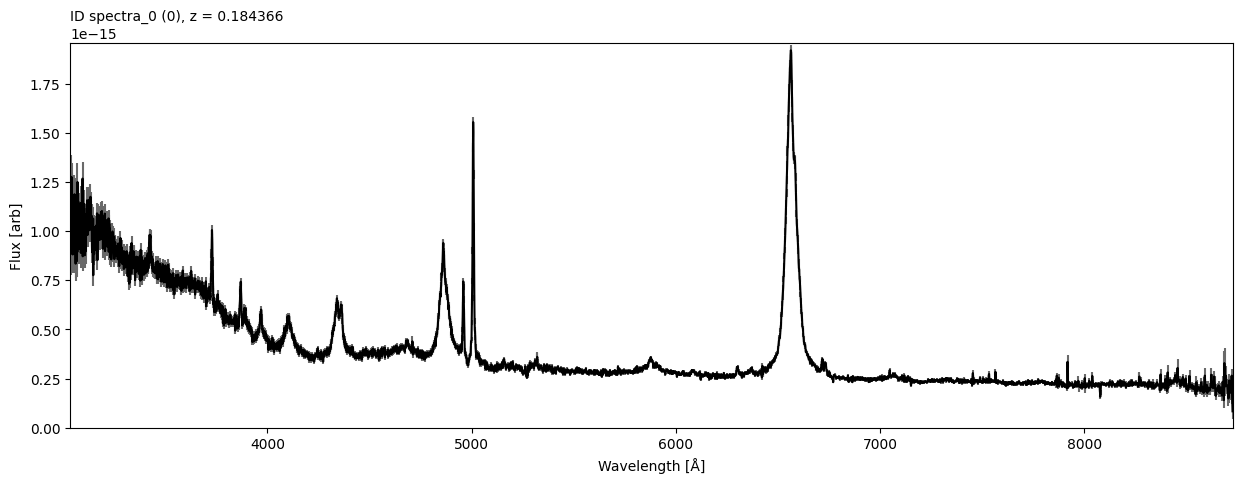

In [6]:
spec_class.quicklook(0)

To fit the spectra first call the instance method `make_complex` on the `spec_class`, which initializes the `ComplexBuilder` class. This class loads YAMLs files that contain most known emission lines and creates a `ComplexRegion` instance with all relevant information about the lines and fit regions. It forms the foundation of the fitting process and includes several key parameters:

- `xmin` and `xmax`: wavelength limits for searching [emission lines](https://sheap.readthedocs.io/en/stable/SuportData/LineRepository/index.html).  
- `n_broad` and `n_narrow`: number of broad and narrow components  
- `continuum_profile`: continuum model to use; *sheap* supports `['linear', 'powerlaw', 'brokenpowerlaw', 'logparabola', 'exp_cutoff', 'polynomial']`  
- `fe_mode`: method for estimating the iron contribution; accepted values are `'none'`, `'model'`, and `'template'`  

In the first example, we fit the Hα region (typically 6000–7200 Å) with a linear continuum profile and no iron contribution.

In [7]:
spec_class.makecomplex(6000,7200,n_broad=1,n_narrow=1,fe_mode ="template",continuum_profile="brokenpowerlaw",add_winds=True,group_method=True,add_host_miles = False,add_outflow=False)

Added feuvop template


When the region is already defined, we can call another important instance method of the class—`.fitcomplex()`—which invokes the fitting process implemented in the `ComplexFitting` class.  

Its main parameters are:

- `list_num_steps=[1_000]`: a list containing the number of iterations to perform.  
- `list_learning_rate=[1e-2]`: a list containing the learning rates to try.  
- `run_uncertainty_params=False`: whether to run the uncertainty estimation (we’ll compute uncertainties later).    
- `add_penalty_function=False`: whether to include a penalty function in the loss.  
- `penalty_weight=0.01`: weight applied to the penalty function.  
- `curvature_weight=1e3`: weight applied to the curvature regularization term.  
- `smoothness_weight=1e5`: weight applied to the smoothness regularization term.  
- `max_weight=0.1`: maximum weight scaling factor for constraints.  

By default, these values are pre-set to reasonable choices but can be changed depending on the needs of the user and the complexity of the spectra being fitted.  

In this example, we disable uncertainty estimation (`run_uncertainty_params=False`) and compute uncertainties in a separate step. Note that `list_num_steps` and `list_learning_rate` must have the same length, since each entry in `list_learning_rate` is paired with the corresponding number of steps in `list_num_steps`.  


In [8]:
spec_class.fitcomplex(list_num_steps=[1_000],list_learning_rate=[1e-2],add_penalty_function=False,
                         penalty_weight = 0.01,curvature_weight=1e3,smoothness_weight=1e5,max_weight=0.1)

cutting between 6000 7200
Fitting 2 spectra with 4590 wavelength pixels

STEP1 (step1) free params 30
learning_rate: 0.01 num_steps: 1000 non_optimize_in_axis: 4
Time for step 'step1': 11.78 seconds
The entire process took 11.78 (5.89s by spectra)


After fitting, you can visualize the results by calling:

```python
spec_class.modelplot.plot()

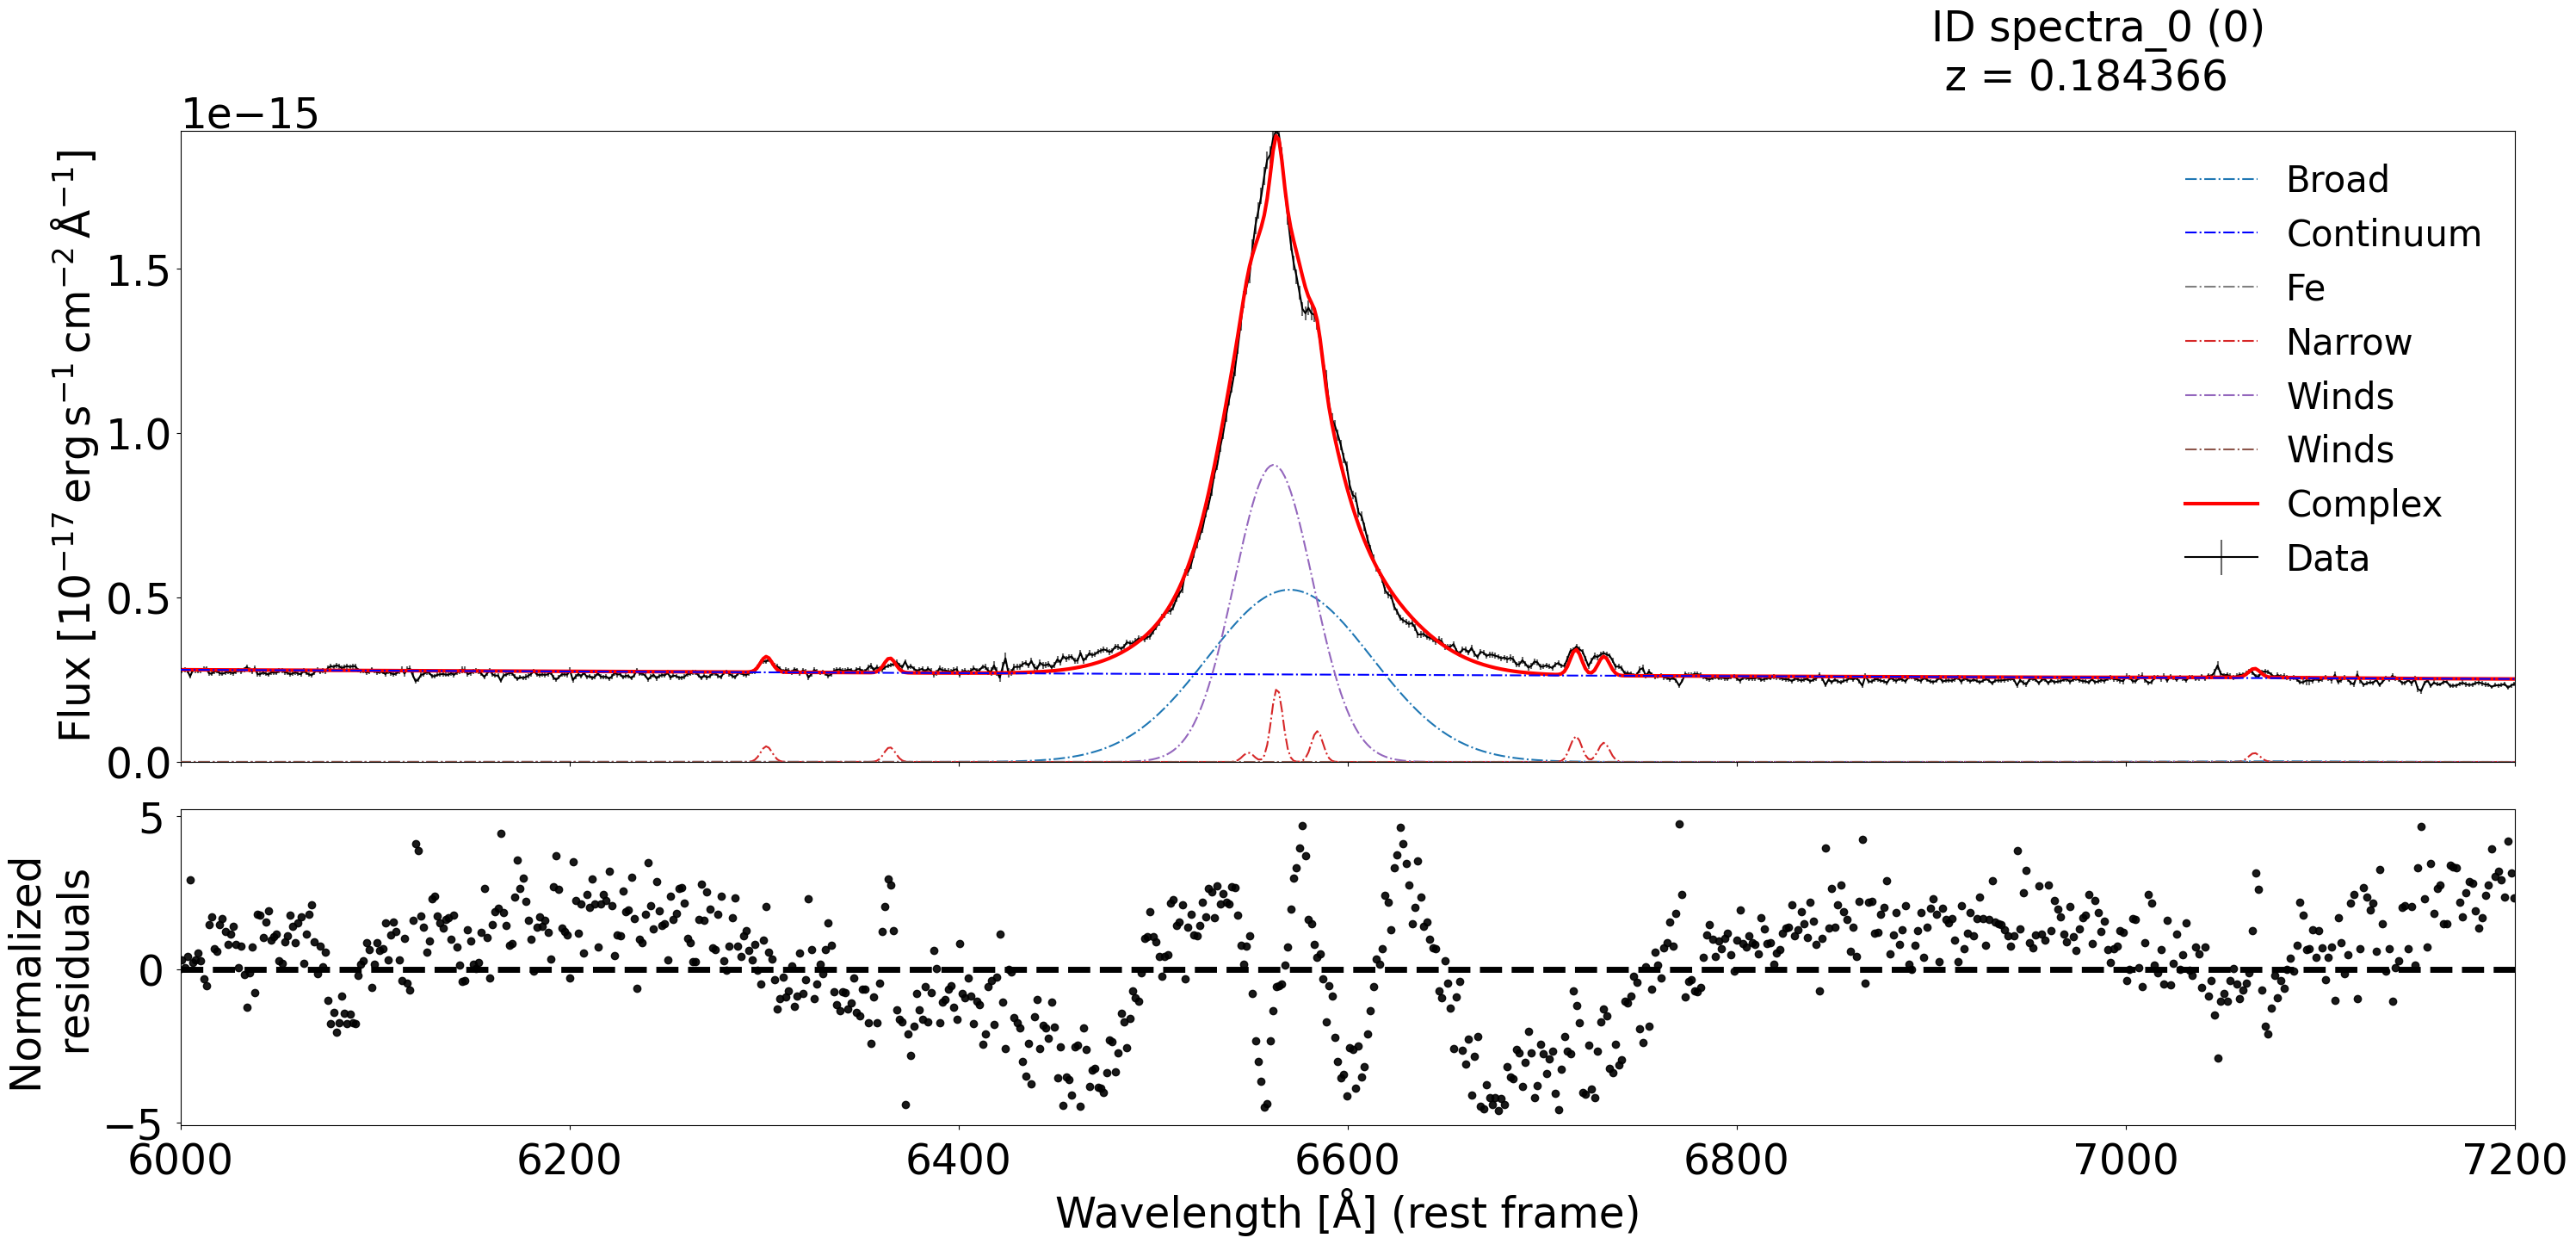

In [9]:
spec_class.modelplot.plot(0)

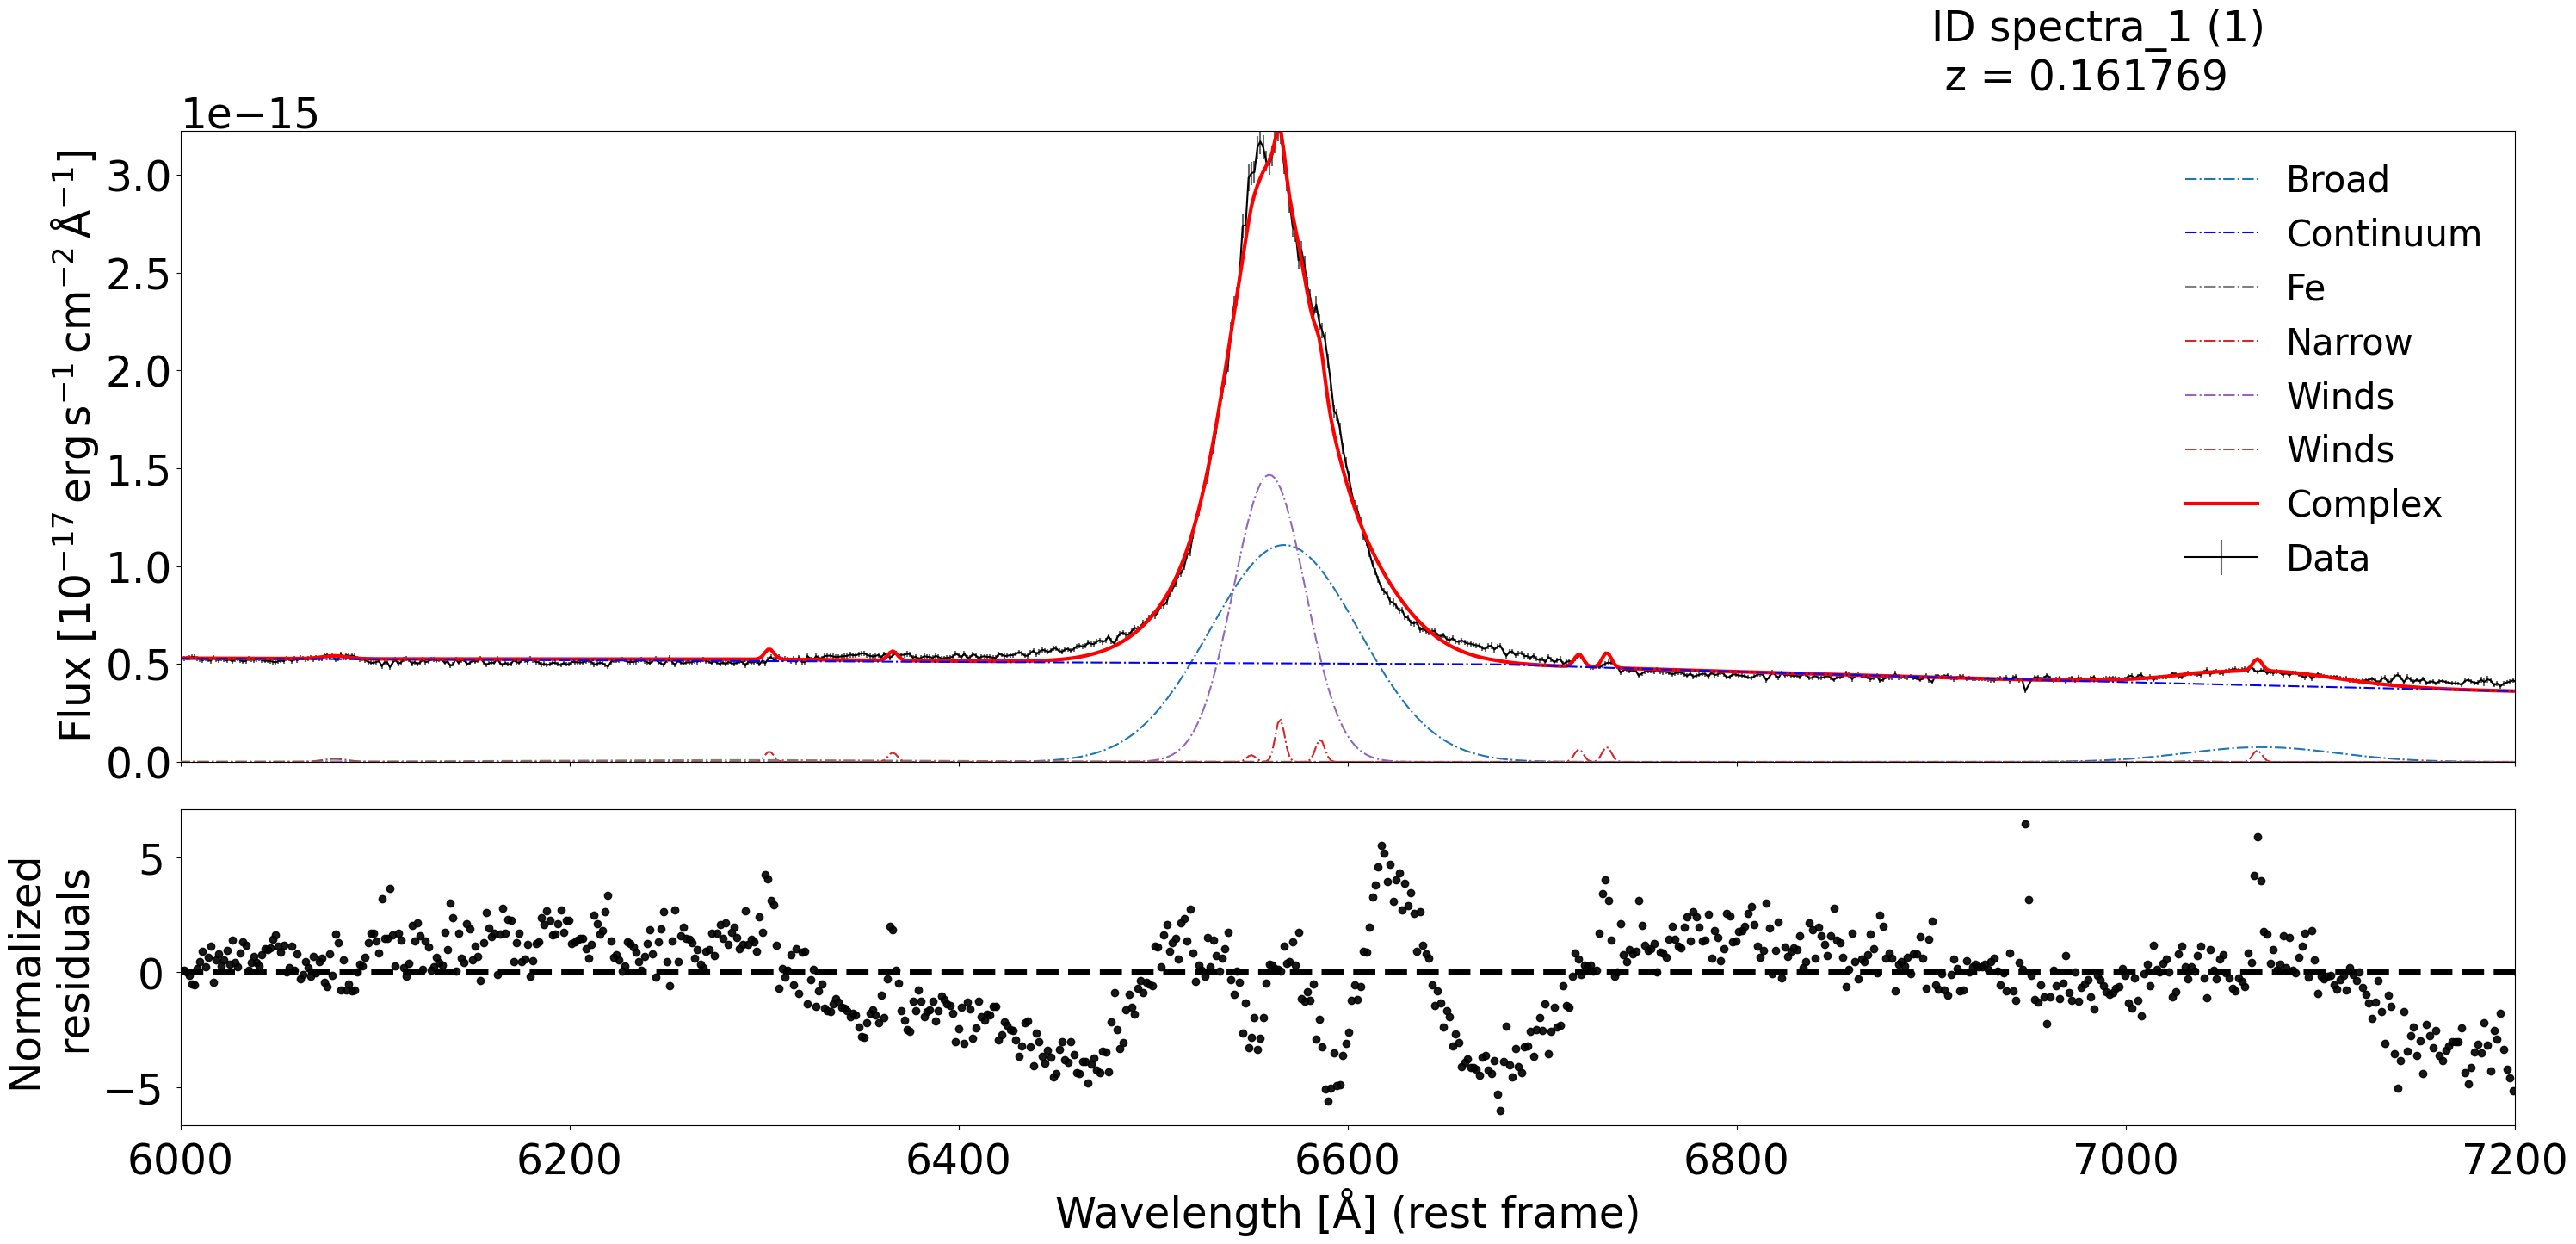

In [10]:
spec_class.modelplot.plot(1)

It is easy to see that the fit is not perfect — the poor fit occurs because it requires more components to be fitted effectively.  
We will see how to improve the fitting in the next notebooks.  

Finally, we will show the instance `posterior_params`, which uses the `ComplexAfterFit` class.  
Currently, *sheap* can handle several types of posterior-parameter estimation:

- The Monte Carlo method  
- The pseudo Monte Carlo method  
- The covariance matrix method  
- MCMC powered by the NumPyro package  

*sheap* can also summarize the samples and estimate posterior parameters such as luminosity, supermassive black hole mass, among others.


In [14]:
spec_class.afterfit(sampling_method="pseudomontecarlo",summarize=False,overwrite=True)

No dependencies


Sampling obj:   0%|          | 0/2 [00:00<?, ?it/s]

/home/felipe/work/MyPackages/sheap/sheap/ComplexAfterFit/AfterFitParams.py:424: RuntimeWarning: overflow encountered in power
  amps = 10**params_by_line[:, :, 0]
/home/felipe/work/MyPackages/sheap/sheap/ComplexAfterFit/Samplers/utils/physicalfunctions.py:220: RuntimeWarning: divide by zero encountered in log10
  logM = np.log10(f) + a + b * (np.log10(L) - np.log10(L0)) + beta * (np.log10(V) - np.log10(V0))
/home/felipe/work/MyPackages/sheap/sheap/ComplexAfterFit/Samplers/utils/physicalfunctions.py:220: RuntimeWarning: invalid value encountered in log10
  logM = np.log10(f) + a + b * (np.log10(L) - np.log10(L0)) + beta * (np.log10(V) - np.log10(V0))
/home/felipe/work/MyPackages/sheap/sheap/ComplexAfterFit/Samplers/utils/physicalfunctions.py:326: RuntimeWarning: divide by zero encountered in log10
  "log10_smbh": np.log10(MBH),
Sampling obj:  50%|█████     | 1/2 [00:12<00:12, 12.48s/it]

no sumerize?


/home/felipe/work/MyPackages/sheap/sheap/ComplexAfterFit/AfterFitParams.py:424: RuntimeWarning: overflow encountered in power
  amps = 10**params_by_line[:, :, 0]
Sampling obj: 100%|██████████| 2/2 [00:20<00:00, 10.24s/it]

no sumerize?


In [16]:
spec_class.result.posterior[1]["spectra_0"]

{'basic_params': {'broad': {'lines': ['Halpha', 'HeIf', 'OIa', 'OIb'],
   'component': [1, 1, 1, 1],
   'flux': array([[5.45847711e-14, 7.61603278e-16, 1.60561848e-08, 9.29427142e-09],
          [5.57579630e-14, 1.02791201e-15, 1.02747707e-44, 7.47197408e-24],
          [5.37563522e-14, 2.83437464e-16, 1.38654399e-37, 1.92980379e-12],
          ...,
          [5.29486574e-14, 6.04721570e-15, 1.47174630e-49, 1.13145859e-31],
          [5.47960931e-14, 4.83311971e-16, 3.69271929e-03, 8.88287885e-14],
          [5.40299490e-14, 2.05177133e-15, 3.95593024e-24, 1.18416861e-14]],
         shape=(2000, 4)),
   'fwhm': array([[ 98.61297479,  98.61297479,  98.61297479,  98.61297479],
          [ 96.90226907,  96.90226907,  96.90226907,  96.90226907],
          [ 99.28136063,  99.28136063,  99.28136063,  99.28136063],
          ...,
          [100.45259247, 100.45259247, 100.45259247, 100.45259247],
          [ 99.32434674,  99.32434674,  99.32434674,  99.32434674],
          [100.98263443, 100.

To study the results, the easiest approach is to use the `result` property of the `spec_class` object. This returns a `ComplexResult` instance that contains the region, parameter results, and, most importantly, the posterior. The posterior is represented as a list where:

1. Index `[0]` holds the basic posterior parameters.  
2. Index `[1]` contains all the line information, organized by the names specified by the user when initializing the code—in this case, `['spectra_0', 'spectra_1']`.  


When we inspect the resulting dictionary in detail, it contains the following keys:

`TODO: update the params that can be calculate and how to take it.`
- `basic_params`: Values for the individual lines in the fit. Since SHEAP groups lines into “templates” that share shift and FWHM, `basic_params` separates these lines for detailed analysis.  
- `L_w` and `L_bol`: The luminosity at a specific wavelength (`L_w`) and the bolometric luminosity (`L_bol`).  
- `extras_params`: Additional parameters for each line. For example, for Hα it includes:  
  - `L_w`  
  - `L_bol`  
  - `fwhm_kms`  
  - `log10_smbh`  
  - `Ledd`  
  - `mdot_msun_per_year`  
- `params_dict_values`: The fitted parameters and their posterior distributions. Note that these parameters remain combined, so their keys follow the pattern `nameparam_linename_region`. For combined lines, `linename = region + component`.  


Finally, to save your results, call the `save_to_pickle` method on the instance.


In [14]:
spec_class.save_to_pickle("dic1.pkl")

Estimated pickle size: 168.64 KB


To load saved results for further testing or new models, use the `from_pickle` class method:

```python
new_instance = Sheapectral.from_pickle('path/to/your_saved_results.pkl')


In [15]:
spec_class_readed = Sheapectral.from_pickle("dic1.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'dic1.pkl'

To reproduce the same plot, simply call the `modelplot.plot()` method again:

```python
spec_class_readed._fit_instance.modelplot.plot()


In [168]:
# spec_class.result.posterior[1]["basic_params"]["broad"]["luminosity"]

**End tutorial 1.**